In [12]:
! pip install mediapy scikit-learn

In [13]:
# импорт зависимостей
import cv2
import mediapy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# настройка matplotlib
%config InlineBackend.figure_format = "retina"
plt.style.use("seaborn-v0_8-notebook")

# путь к данным
DATA_DIR = Path("./06")

---
### **Сегментация изображений**

<img src="./06/fig1.jpg" width=400/>
<img src="./06/fig2.jpg" width=400/>

**Сегментация изображений** – объединение пикселей по признакам.

В качестве признаков могут быть:

- цветовые координаты пикселей в пространстве RGB, HSV и т.д.

- пространственные координаты пикселей (x, y)

- признаки, полученные с помощью нейронных сетей

- метки классов объектов (например, человек, машина, дорога и т.д.)

---
### **Примеры использования сегментации изображений**

<img src="./06/road_seg.jpg" height=200/>
<img src="./06/med_seg.jpg" height=200/>
<img src="./06/sat_segm.jpg" height=200/>

Cегментация изображений используется в различных областях:

- автономное вождение

- медицинская диагностика

- анализ спутниковых изображений


---
### **Сегментация на основе классификации пикселей**

<img src="./06/segm_types.jpg" width=900/>

Каждому пикселю изображения присваивается метка класса.

- требуется обучающая выборка с разметкой

- можно использовать любые алгоритмы классификации (SVM, Random Forest, нейронные сети и т.д.)

- высокое качество сегментации при наличии хорошей обучающей выборки

Виды сегментации на основе классификации пикселей:

- **semantic segmentation** - каждому пикселю присваивается метка класса

- **instance segmentation** - не только классифицировать пиксели по классу, но и отличать друг от друга отдельные экземпляры объектов одного класса

- **panoptic segmentation** - объединяет semantic и instance сегментацию

*Демка сегментации с помощью SAM2 (Segment Anything 2, 11M images, 1B+ masks)*

https://sam2.metademolab.com/demo

---
### **Пороговая cегментация**

<figure>
    <img src="./06/thresh_segm.jpg" style="width:70%"/>
</figure>

Алгоритм бинарной пороговой сегментации:

- на гистограмме выбрать порог $T$
- сегментировать изображение $f$ по порогу $T$
$$
    g(x, y) =
    \begin{cases}
        0\,, & f(x,y) \leqslant T \\        
        255\,, & f(x,y) > T
    \end{cases}
$$

---
##### **Пример пороговой сегментации**

Построим гистограмму яркости изображения.

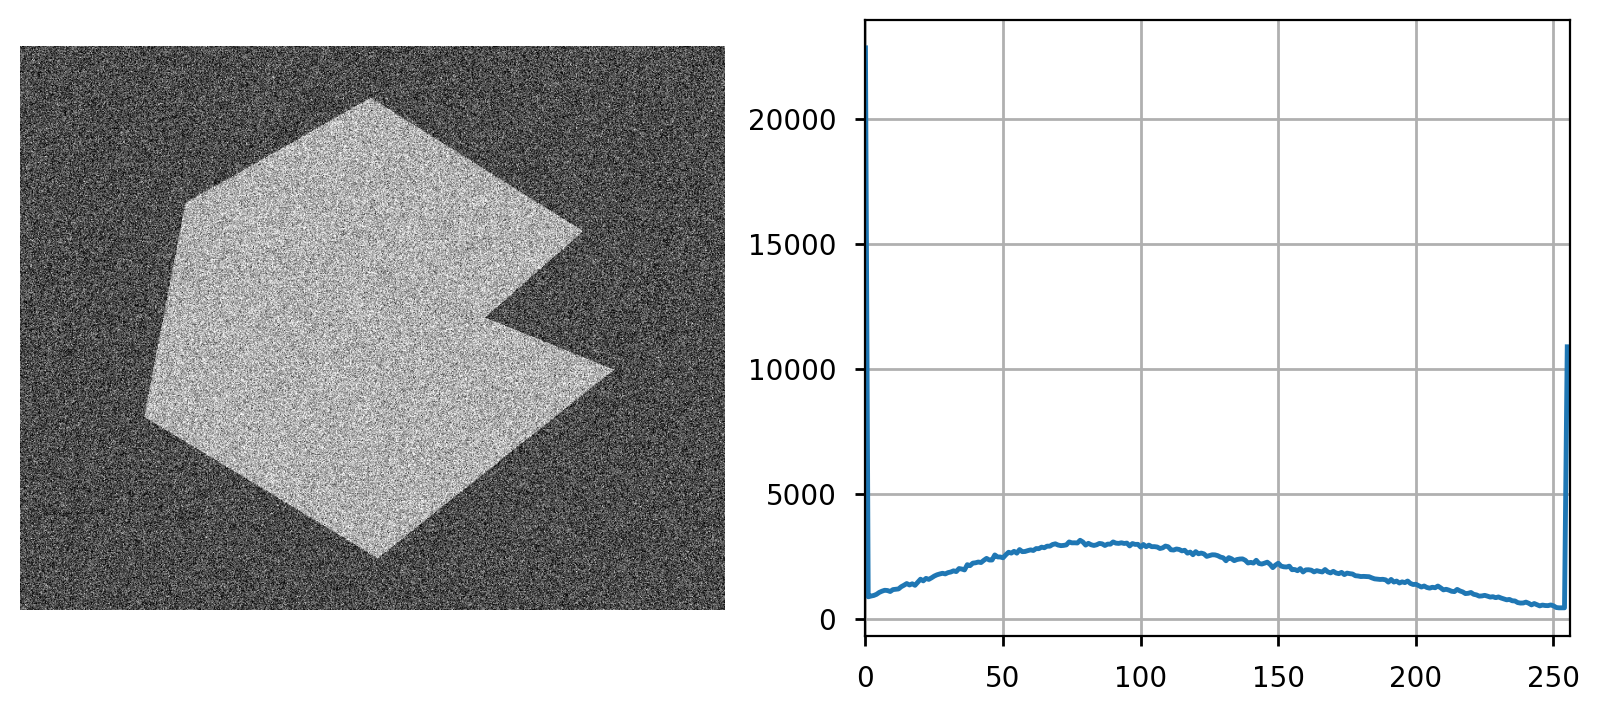

In [14]:
# читаем grayscale изображение
src_image = cv2.imread(DATA_DIR / "gaussian_noise.png", cv2.IMREAD_GRAYSCALE)

# вычисление гистограммы
hist = cv2.calcHist([src_image], [0], None, [256], [0, 256])

# графики
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.axis("off")
plt.imshow(src_image, cmap="gray")
plt.subplot(122)
plt.plot(hist)
plt.xlim([0, 256])
plt.grid(True)

Перед выбором порога изображение нужно сгладить, чтобы уменьшить шум.

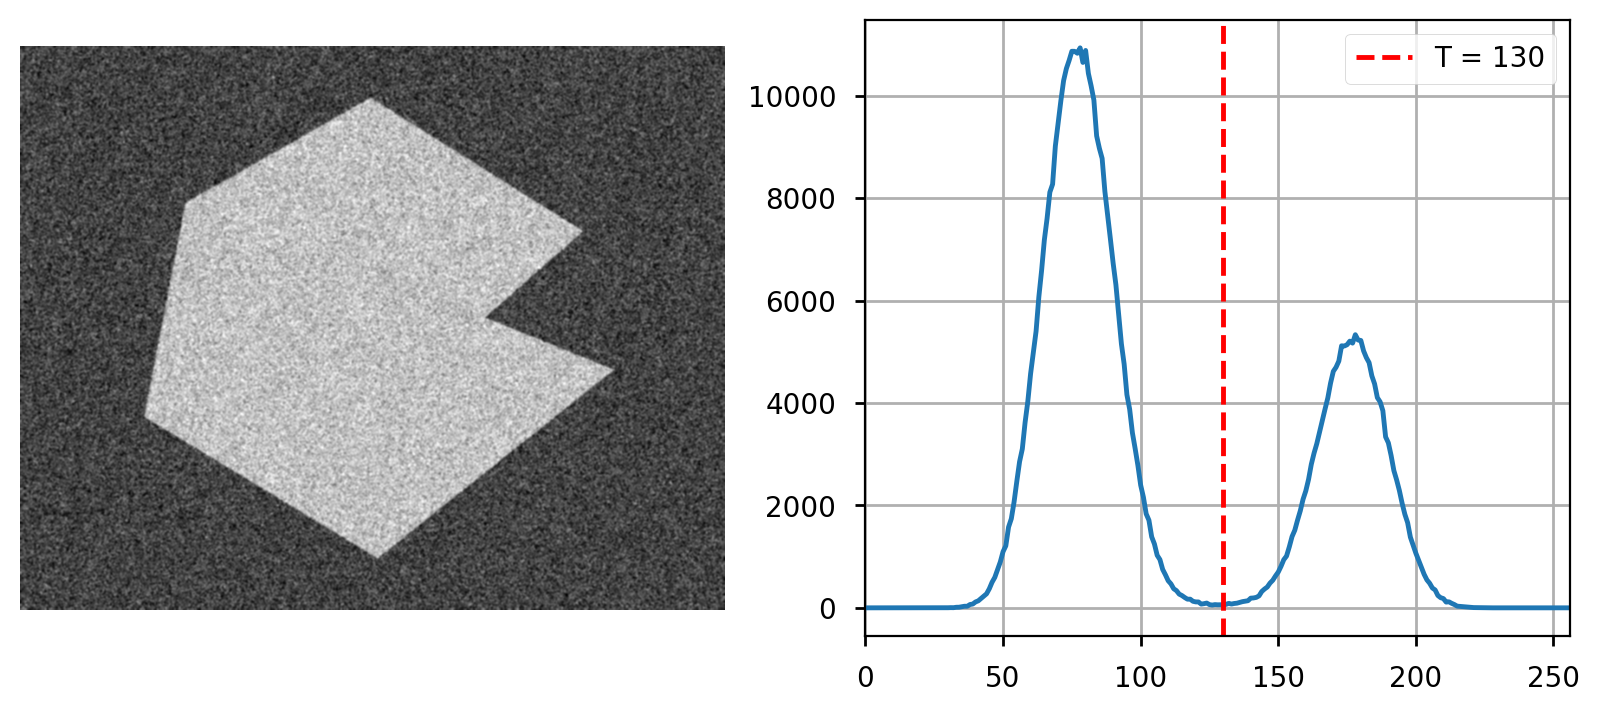

In [15]:
# гауссовское сглаживание 5 x 5
blur_image = cv2.GaussianBlur(src_image, (5, 5), sigmaX=0)

# вычисление гистограммы
hist = cv2.calcHist([blur_image], [0], None, [256], [0, 256])

# порог сегментации
T = 130

# графики
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.axis("off")
plt.imshow(blur_image, cmap="gray")
plt.subplot(122)
plt.plot(hist)
plt.axvline(x=T, color="r", linestyle="--", label=f"T = {T}")
plt.xlim([0, 256])
plt.legend()
plt.grid(True)

Выполним пороговую сегментацию с выбранным порогом.

исходное изображение,сегментация по порогу T = 130

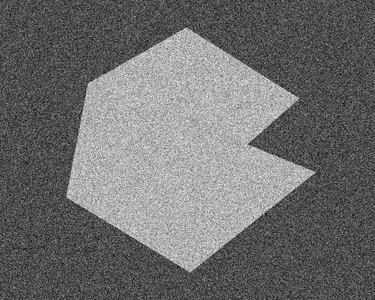
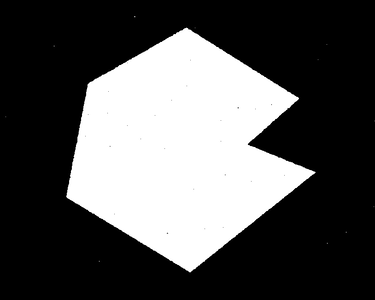

In [16]:
# пороговая сегментация
T = 130
mask = np.uint8(255 * (blur_image > T))

# графики
mediapy.show_images({
    "исходное изображение": src_image, 
    f"сегментация по порогу T = {T}": mask
}, border=True, height=300)

---
### **Метод Оцу вычисления порога бинарной сегментации**

<figure>
    <img src="./06/thresh_segm.jpg" style="width:70%"/>
</figure>

Как выбрать порог $T$ алгоритмически?

Алгоритм Оцу:

- для каждого порога $T=1,2,\ldots,255$, разобьем все пиксели на два класса
$$
    C_1 = \left\{(x,y): f(x,y) < T\right\}\,,\quad
    C_2 = \left\{(x,y): f(x,y) \geqslant T\right\}
$$

-  выберем порог так, что бы дисперсия значений пикселей в каждом классе была минимальна
    $$
        T_\ast=\argmin_{0 < T < 256} 
        \left[\sigma_1^2(T)  + \sigma_2^2(T)\right]
    $$
    где $\sigma_1^2, \sigma_2^2$ - дисперсии яркостей пикселей в классах $C_1$ и $C_2$.

---
##### **Пример пороговой сегментации с помощью метода Оцу**

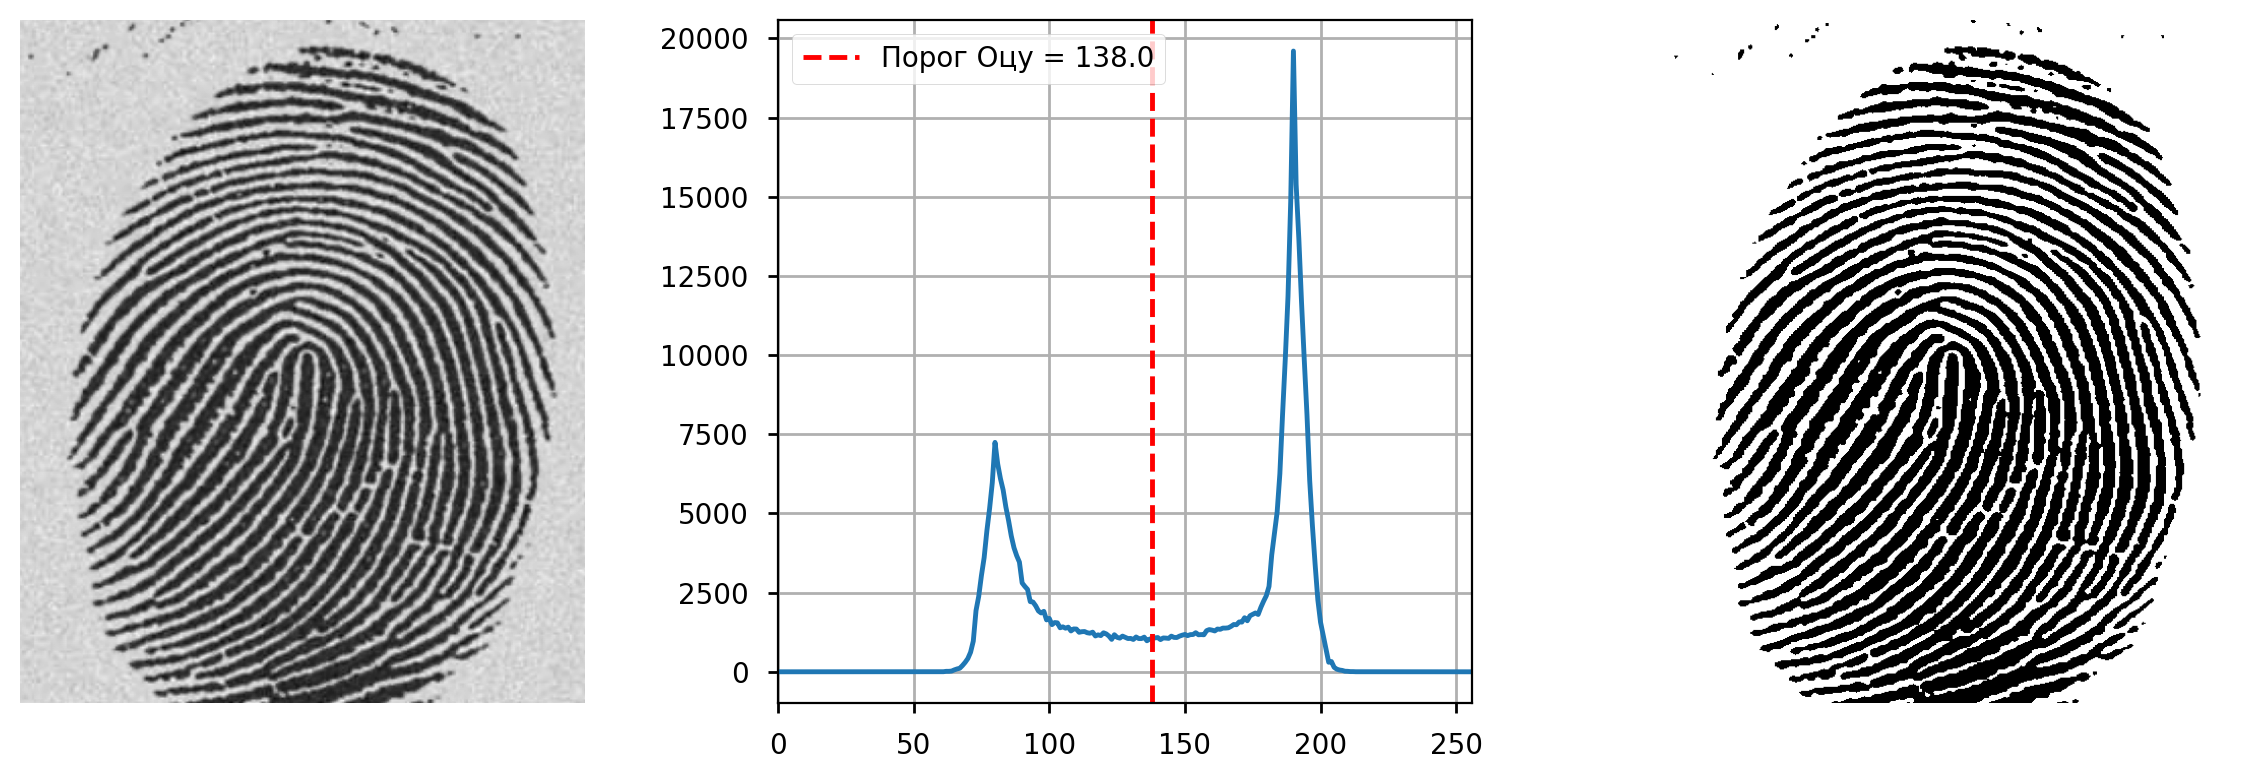

In [17]:
# читаем grayscale изображение
image = cv2.imread(DATA_DIR / "fingerprint.png", cv2.IMREAD_GRAYSCALE)

# вычисление порога методом Оцу и сегментация изображения
T, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# вычислим гистограмму
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

# графики
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.subplot(132)
plt.plot(hist)
plt.axvline(x=T, color="r", linestyle="--", label=f"Порог Оцу = {T}")
plt.xlim([0, 256])
plt.legend()
plt.grid(True)
plt.subplot(133)
plt.axis("off")
plt.imshow(mask, cmap="gray")
plt.tight_layout()


---
### **Сегментация с помощью кластеризации пикселей**

<figure>
    <img src="./06/peppers.jpg" style="width:40%"/>
    <img src="./06/meanshift15.jpg" style="width:40%"/>
</figure>

Пиксели описываются признаками.

Кластеризуя пиксели по признакам, можно получить сегментацию.

В качестве признаков могут быть:

- цветовые координаты пикселей в пространстве RGB, HSV, YCrCb и т.д.

- пространственные координаты пикселей (x, y)

- признаки, полученные с помощью нейронных сетей


---
### **3-means кластеризация точек на плоскости**

<figure>
    <img src="./06/3means.jpg" style="width:90%"/>
</figure>

**Задача:** разбить точки на плоскости на 3 кластера.

**Решение:**

1. инициализировать 3 центра кластеров (случайно или по определенному правилу)

2. создать кластеры, отнеся каждую точку к ближайшему центру

3. пересчитать центры кластеров как среднее значение точек в кластере

4. повторять шаги 2-3, пока центры кластеров не перестанут меняться

---
### **k-means кластеризация**

**Заданы:** $N$ точек в пространстве признаков $\mathbf{z}_n\in\mathbf{R}^d$ и число кластеров $k$

**Задача:** найти $k$ кластеров

**k-means алгоритм**

1. инициализировать $k$ центров кластеров $\mathbf{m}_1,\ldots,\mathbf{m}_k\in\mathbf{R}^d$

2. для каждой точки $\mathbf{z}_n$ найти ближайший центр кластера $\mathbf{m}_i$ и отнести точку к  кластеру $C_i$

$$
    \mathbf{z}_n \in C_i \quad \text{если} \quad \|\mathbf{z}_n - \mathbf{m}_i\| < \|\mathbf{z}_n - \mathbf{m}_j\|, \quad j \neq i
$$

3. пересчитать центры кластеров как среднее значение точек в кластере
$$
    \mathbf{m}_i = \frac{1}{|C_i|} \sum_{\mathbf{z}_n \in C_i} \mathbf{z}_n
$$

4. повторять шаги 2-3 пока изменения во всех центрах кластеров не станут меньше $\varepsilon$

**Свойства k-means кластеризации**

- простой и быстрый алгоритм
- требует задания числа кластеров 𝑘
- чувствителен к выбору начальных центров кластеров
- чувствителен к выбросам

---
##### **Пример: k-means сегментация изображения**

исходное изображение

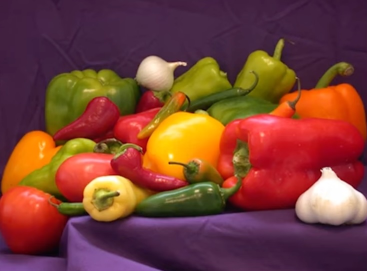

In [18]:
# читаем RGB изображение
image = cv2.imread(DATA_DIR / "peppers.jpg", cv2.IMREAD_COLOR_RGB)
image = cv2.resize(image, fx=0.5, fy=0.5, dsize=None)

# графики
mediapy.show_images({
    "исходное изображение": image,
}, border=True, height=350)

In [19]:
# преобразуем в набор точек (num_points, 3) - (R, G, B) цвета
z = image.reshape(-1, 3) 
num_points = z.shape[0]

# графики цветов пикселей в 3D
import plotly.express as px
import plotly.graph_objects as go

plots = []

# точки прзнаков (цветов пикселей)
p = px.scatter_3d(
    x=z[:, 0], y=z[:, 1], z=z[:, 2],
    color=num_points * ["gray"],
    color_discrete_map="identity"
)
p.update_traces(marker_size=1)
plots.append(p)

# оси координат
p = px.line_3d(x=[0, 255], y=[0, 0], z=[0, 0])
p.update_traces(line=dict(color="red", width=7))
plots.append(p)

p = px.line_3d(x=[0, 0], y=[0, 255], z=[0, 0])
p.update_traces(line=dict(color="green", width=7))
plots.append(p)

p = px.line_3d(x=[0, 0], y=[0, 0], z=[0, 255])
p.update_traces(line=dict(color="blue", width=7))
plots.append(p)

# рендеринг сцены
data = []

for p in plots:
    data += p.data

fig = go.Figure(data)

fig.update_layout(autosize=True, width=800, height=600, paper_bgcolor="white",
    scene=dict(
        aspectmode="data",
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

view = dict(
    eye=dict(x=1, y=1, z=1),
    center=dict(x=0, y=0, z=0),
    up=dict(x=0, y=0, z=1)
)

fig.update_layout(scene_camera=view)
fig.show()

In [20]:
from sklearn.cluster import KMeans

# зададим число классов
K = 10

# k-means кластеризация
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto") 
kmeans.fit(z)

# номера кластеров для каждой точки
labels = kmeans.labels_

#  центры кластеров
cluster_centers = kmeans.cluster_centers_.astype(int)

plots = []

# графики кластеров
for k in range(K):
    mask = (labels == k)
    r = z[mask, 0]
    g = z[mask, 1]
    b = z[mask, 2]
    mean_color = cluster_centers[k]
    num_pts = len(r)
    
    p = px.scatter_3d(
        x=z[mask, 0], y=z[mask, 1], z=z[mask, 2],
        color=num_pts * [f"rgb({mean_color[0]}, {mean_color[1]}, {mean_color[2]})"],
        color_discrete_map="identity"
    )
    p.update_traces(marker_size=1)
    plots.append(p)

# оси координат
p = px.line_3d(x=[0, 255], y=[0, 0], z=[0, 0])
p.update_traces(line=dict(color="red", width=7))
plots.append(p)

p = px.line_3d(x=[0, 0], y=[0, 255], z=[0, 0])
p.update_traces(line=dict(color="green", width=7))
plots.append(p)

p = px.line_3d(x=[0, 0], y=[0, 0], z=[0, 255])
p.update_traces(line=dict(color="blue", width=7))
plots.append(p)

# рендеринг сцены
data = []

for p in plots:
    data += p.data

fig = go.Figure(data)

fig.update_layout(
    autosize=True, width=800, height=600, paper_bgcolor="white",
    scene=dict(
        aspectmode="data",
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

view = dict(
    eye=dict(x=1, y=1, z=1),
    center=dict(x=0, y=0, z=0),
    up=dict(x=0, y=0, z=1)
)

fig.update_layout(scene_camera=view)
fig.show()

исходное изображение,k-means сегментация

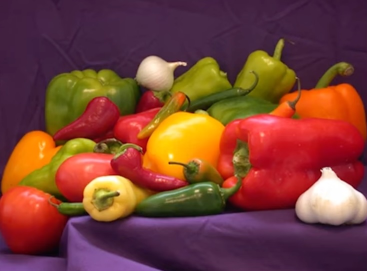
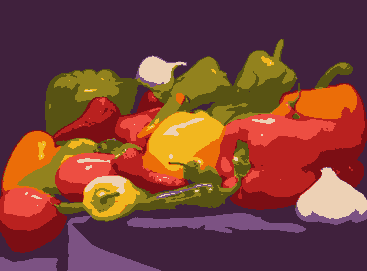

In [21]:
# вычислим выходное сегментационное изображение
segmented_image = np.zeros_like(image)
h, w = image.shape[:2]

# ресайз маски в исходный размер изображения
mask = kmeans.labels_.reshape(h, w)

for k in range(K):
    # координаты точек в кластере
    y, x = np.where(mask == k)
    # пиксели кластера
    cluster_pixels = image[y, x]
    # средний цвет кластера
    cluster_color = np.uint8(cluster_pixels.mean(axis=0))
    # запишем средний цвет в выходное изображение
    segmented_image[y, x] = cluster_color

# графики
mediapy.show_images({
    "исходное изображение": image,
    "k-means сегментация": segmented_image
}, border=True, height=300)

---
### **Влияние пространственных признаков на k-means сегментацию**

<figure>
    <img src="./06/kmeans6.jpg" style="width:40%"/>
    <img src="./06/kmeans7.jpg" style="width:40%"/>
</figure>

- слева сегментация по цветовым признакам: 
$$
    \mathbf{z}=(R,G,B)
$$

- справа сегментация по цветовым и пространственным признакам:
$$
    \mathbf{z}=(R,G,B, x, y)
$$


---
### **Mean-shift кластеризация**

<figure>
    <img src="./06/meanshift1.jpg" style="width:30%"/>
    <img src="./06/meanshift3.jpg" style="width:30%"/>
    <img src="./06/meanshift2.jpg" style="width:30%"/>
</figure>

**На рисунке**:

- Точки признаков 

- Плотность распределения признаков

- Кластеры, найденные mean-shift алгоритмом

**Mean-shift кластеризация**:

- каждый холм представляет кластер

- пики холмов - центры кластеров

- каждая точка взбирается по самому крутому холму 

- точки, взобравшиеся на один холм, образуют кластер

---
### **Mean-shift: как точки взбираются на холмы?**

<figure>
    <img src="./06/meanshift4.png" style="width:30%"/>
    <img src="./06/meanshift5.png" style="width:30%"/>
    <img src="./06/meanshift6.png" style="width:30%"/>
</figure>

- каждая точка $\mathbf{z}_n$ сдвигается в сторону среднего значения точек в
окрестности радиуса $R$

<figure>
    <img src="./06/meanshift7.png" style="width:30%"/>
    <img src="./06/meanshift8.png" style="width:30%"/>
    <img src="./06/meanshift9.png" style="width:30%"/>
</figure>

- каждая точка $\mathbf{z}_n$ сдвигается пока не перестанет меняться

- точки, которые сойдутся в одну точку, образуют кластер

---
### **Свойства mean-shift кластеризации**

- простой алгоритм, но вычислительно дорогой

- находит число кластеров автоматически

- не требует инициализации центров кластеров

- нечувствителен к выбросам

- кластеризация зависит от радиуса окрестности 𝑅


---
### **Сравнение качества mean-shift и k-means сегментации**

<figure>
    <img src="./06/peppers.jpg" style="width:30%"/>
    <img src="./06/meanshift14.png" style="width:30%"/>
    <img src="./06/meanshift15.png" style="width:30%"/>
</figure>

- изображение слева - оригинал

- изображение в центре - k-means сегментация c параметрами:
$$
    \mathbf{z}=(R,G,B, x, y)\,,\qquad k=16
$$

- изображение справа - mean-shift сегментация с параметрами
$$
    \mathbf{z}=(R,G,B, x, y)\,,\qquad R=15
$$

---
##### **Пример mean-shift сегментации изображения в OpenCV**

исходное изображение,mean-shift сегментация

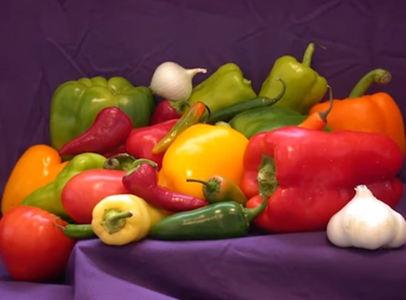
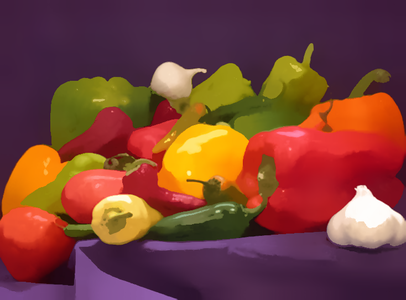

In [22]:
# читаем BGR изображение
image = cv2.imread(DATA_DIR / "peppers.jpg", cv2.IMREAD_COLOR_BGR)

# OpenCV Mean Shift сегментация
segmented_image = cv2.pyrMeanShiftFiltering(
    image, 
    sp=20, # радиус окрестности для пространственных координат (x, y)
    sr=40, # радиус окрестности для цветовых координат (R, G, B)
    maxLevel=1 # число уровней в пирамиде Гаусса
)

# графики
mediapy.show_images({
    "исходное изображение": image[:, :, ::-1], # BGR -> RGB 
    "mean-shift сегментация": segmented_image[:, :, ::-1]
}, border=True, height=300)

#### **Домашняя работа 6**

##### **Теория**

- Виды сегментации изображений. Примеры использования.

- Пороговая сегментация изображений. Метод Оцу вычисления порога.

- Алгоритм k-means кластеризации. Свойства k-means кластеризации. Сегментация с помощью k-means кластеризации.

- Алгоритм mean-shift кластеризации. Свойства mean-shift кластеризации. Сегментация с помощью mean-shift кластеризации.

